# CNN using pytorch course

## Preparing data

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
mean_gray = 0.1307
stddev_gray = 0.3081

transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray),(stddev_gray))])

train_dataset =  datasets.MNIST(root='./data', train=True, transform=transforms, download=True)

test_dataset = datasets.MNIST(root='./data',
                             train=False,
                             transform=transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 108643259.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42090234.13it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25083933.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10182003.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



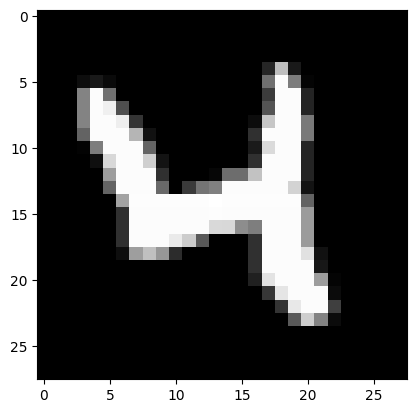

In [3]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28, 28), cmap='gray')

In [4]:
train_dataset[20][1]

4

In [5]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)

test_load = torch.utils.data.DataLoader(dataset=test_dataset,
                                       batch_size=batch_size,
                                       shuffle=False)



In [6]:
len(train_load)

600

## building the model 

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1,
                             out_channels=8,
                             kernel_size=3,
                             stride=1,
                             padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # the output size
        self.cnn2 = nn.Conv2d(in_channels=8,
                             out_channels=32,
                             kernel_size=5,
                             stride=1,
                             padding=2)
        # Output size of each of the 32 feature maps()
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(1568, 600)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(600, 10)
        
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(-1, 1568)
        # then we forward through out fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [8]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.01)


In [9]:
# Training the CNN
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i,(inputs, labels) in enumerate(train_load):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
        
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100*correct/len(train_dataset))
    
    testing_loss = 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    for i, (inputs, labels) in enumerate(test_load):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        testing_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations +=1
        
    test_loss.append(testing_loss/iterations)
    test_accuracy.append((100*correct/len(test_dataset)))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[-1]}, Training Accuracy: {train_accuracy[-1]}, Testing Loss: {test_loss[-1]}, Testing Accuracy: {test_accuracy[-1]}")
    
        

Epoch 1/10, Training Loss: 0.5087649396434426, Training Accuracy: 87.11666666666666, Testing Loss: 0.06698098596869385, Testing Accuracy: 98.04
Epoch 2/10, Training Loss: 0.14257948209842047, Training Accuracy: 95.935, Testing Loss: 0.04336922458215213, Testing Accuracy: 98.62
Epoch 3/10, Training Loss: 0.09895844761321011, Training Accuracy: 97.21166666666667, Testing Loss: 0.0442423191781927, Testing Accuracy: 98.76
Epoch 4/10, Training Loss: 0.08231086953853567, Training Accuracy: 97.64666666666666, Testing Loss: 0.04109662747866423, Testing Accuracy: 98.58
Epoch 5/10, Training Loss: 0.07467875073043008, Training Accuracy: 97.895, Testing Loss: 0.03510609663743708, Testing Accuracy: 98.99
Epoch 6/10, Training Loss: 0.06197473318025004, Training Accuracy: 98.29166666666667, Testing Loss: 0.04429462802090825, Testing Accuracy: 98.73
Epoch 7/10, Training Loss: 0.06503085973556154, Training Accuracy: 98.09666666666666, Testing Loss: 0.03048190021440405, Testing Accuracy: 99.09
Epoch 8/1

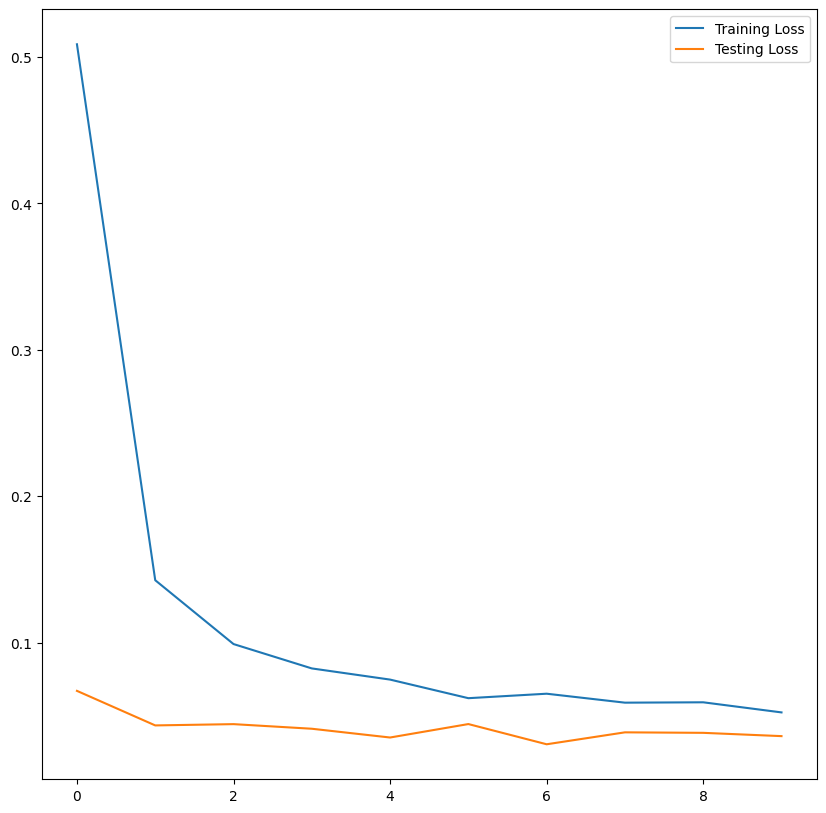

In [10]:
# Plotting the loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

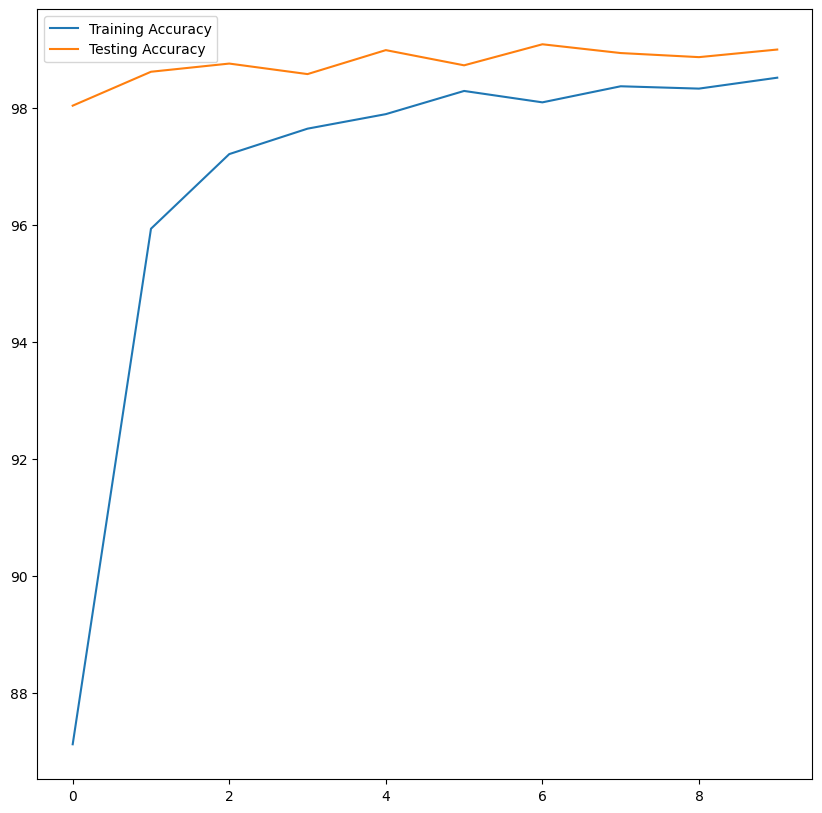

In [11]:
# Plotting the accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

In [12]:
img = test_dataset[30][0].resize_((1,1,28,28))
label = test_dataset[30][1]

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()
    
outputs = model(img)
_, predicted = torch.max(outputs,1)
print(f"Prediction is : {predicted.item()}")
print(f"Actual is : {label}")

Prediction is : 3
Actual is : 3
